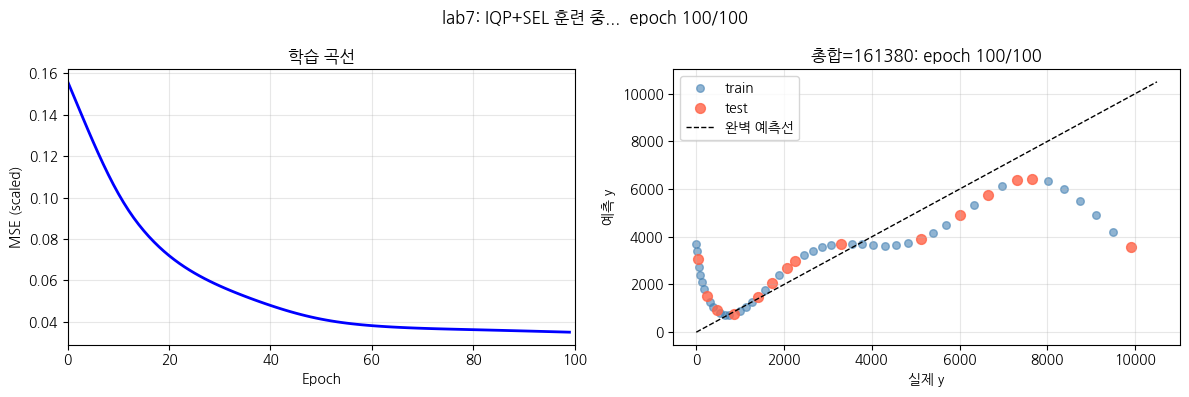

In [3]:
# !pip install pennylane koreanize_matplotlib -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from IPython.display import clear_output
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
n_layers = 3      # Ansatz 레이어 수: 1 / 2 / 3
epochs   = 100
lr       = 0.01   # 학습률: 0.001 / 0.01 / 0.1
# ===== 수정 끝 =====
# ============================================================

# --- Lab 5, 6과 동일한 데이터 ---
x1 = std_np.array([2*i + 1   for i in range(50)], dtype=float)
x2 = std_np.array([2*(i + 1) for i in range(50)], dtype=float)
y  = x1 * x2
THEORY_SUM = 169150

def scale_x(x):     return (x - 1) / 99 * std_np.pi
Y_MIN, Y_MAX = 2.0, 9900.0
def scale_y(y_val): return (y_val - Y_MIN) / (Y_MAX - Y_MIN)
def unscale_y(y_sc): return y_sc * (Y_MAX - Y_MIN) + Y_MIN

x1_sc = scale_x(x1)
x2_sc = scale_x(x2)
y_sc  = scale_y(y)

std_np.random.seed(42)
idx       = std_np.random.permutation(50)
n_train   = 35
idx_train = idx[:n_train]
idx_test  = idx[n_train:]
print(f"  train: {n_train}개, test: {len(idx_test)}개 (셔플)")

# ===========================================================
#  lab7: IQP + StronglyEntanglingLayers VQR
# ===========================================================

print("\n" + "=" * 60)
print("lab7: VQR -- IQP + StronglyEntanglingLayers")
print("=" * 60)

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def vqr_iqp(inputs, weights):
    qml.IQPEmbedding(inputs, wires=[0, 1], n_repeats=1)
    qml.StronglyEntanglingLayers(weights, wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# 파라미터 형상
w_shape  = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=2)
n_params = int(std_np.prod(w_shape))
print(f"  회로 구조: IQPEmbedding + StronglyEntanglingLayers x {n_layers}")
print(f"  파라미터 형상: {w_shape}  ->  총 {n_params}개")

# 회로도 시각화
std_np.random.seed(42)
w_init  = np.array(std_np.random.uniform(0, std_np.pi, w_shape), requires_grad=True)
s_inp   = np.array([x1_sc[0], x2_sc[0]])

fig, _ = qml.draw_mpl(vqr_iqp, decimals=2)(s_inp, w_init)
fig.suptitle(f"lab7: IQP + StronglyEntanglingLayers 회로도 (n_layers={n_layers})", fontsize=12)
plt.show()

# 비용 함수
def vqr_cost(weights):
    total = np.array(0.0)
    for i in idx_train:
        inp  = np.array([x1_sc[i], x2_sc[i]])
        pred = (vqr_iqp(inp, weights) + 1) / 2
        total = total + (pred - y_sc[i]) ** 2
    return total / n_train

# 예측 함수
def vqr_predict(weights):
    preds = []
    for i in range(50):
        inp  = np.array([x1_sc[i], x2_sc[i]])
        p_sc = (float(vqr_iqp(inp, weights)) + 1) / 2
        preds.append(unscale_y(p_sc))
    return std_np.array(preds)

# 학습 (실시간 시각화)
opt      = qml.AdamOptimizer(stepsize=lr)
weights  = w_init.copy()
history  = []

for ep in range(epochs):
    weights = opt.step(vqr_cost, weights)
    loss    = float(vqr_cost(weights))
    history.append(loss)

    if ep % 10 == 0 or ep == epochs - 1:
        clear_output(wait=True)
        preds_now = vqr_predict(weights)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"lab7: IQP+SEL 훈련 중...  epoch {ep+1}/{epochs}", fontsize=12)

        ax1.plot(history, 'b-', lw=2)
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("MSE (scaled)")
        ax1.set_title("학습 곡선")
        ax1.set_xlim(0, epochs); ax1.grid(True, alpha=0.3)

        ax2.scatter(y[idx_train], preds_now[idx_train],
                    c='steelblue', alpha=0.6, s=30, label='train')
        ax2.scatter(y[idx_test],  preds_now[idx_test],
                    c='tomato',    alpha=0.8, s=50, label='test')
        ax2.plot([0, 10500], [0, 10500], 'k--', lw=1, label='완벽 예측선')
        ax2.set_xlabel("실제 y"); ax2.set_ylabel("예측 y")
        ax2.set_title(f"총합={preds_now.sum():.0f}: epoch {ep+1}/{epochs}")
        ax2.legend(); ax2.grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()

In [4]:
# 최종 결과
vqr_preds    = vqr_predict(weights)
vqr_sum      = vqr_preds.sum()
vqr_test_mse = std_np.mean((vqr_preds[idx_test] - y[idx_test]) ** 2)

print(f"  IQP 총합:      {vqr_sum:.1f}  (이론: {THEORY_SUM})")
print(f"  IQP test MSE:  {vqr_test_mse:.2f}")
print(f"  IQP 파라미터:  {n_params}개  (형상: {w_shape})")

print("\nlab7 완료!")

  IQP 총합:      161379.9  (이론: 169150)
  IQP test MSE:  3888377.56
  IQP 파라미터:  18개  (형상: (3, 2, 3))

lab7 완료!
